# Natural Language Processing: Classification of News Articles
This project used the content of news articles to classify them into one of the 4 following categories: `World, Sports, Business, Sci/Tech`.

The original data source is http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html.

The dataset was made available on GCU learn in the compressed file 'news_dataset.zip' where it was simply downloaded and extracted.

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Embedding
)
import tensorflow.keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# 1. Data preparation
Import data. 

In [2]:
# Importing the dataset. As done in lab 4, you usually have a look at the data. Here we simply show the first 5 rows
train_data = pd.read_csv("data/train.csv") # File path was added as the data files were put in a folder
test_data = pd.read_csv("data/test.csv")# File path was added as the data files were put in a folder

train_data.head(5)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


<br>

**Change labels from 1-4 to 0-3**

In [3]:
# substract 1 from the target variable for both, train and test data
train_data["Class Index"] = train_data["Class Index"] - 1
test_data["Class Index"] = test_data["Class Index"] - 1

# Labels
label_names = ["World", "Sports", "Business", "Sci/Tech"] # 0 is "World", 1 is "Sports", 2 is "Business" and 4 is "Sci/Tech"

## Preprocessing 

Lowercase descriptions and clean up of non-letter characters.

**Removing the occurences of "http" "href", "https" and "www". Also, removing the names of the news agencies (Reuters, AP, ...) from the datasets.**

Upon careful observation, it was noted that news agency names, when present, were added at the end of each news title within parentheses in the `Title` column. To address this, the names of these agencies will be extracted from the column and subsequently removed from the dataset used for model training.

#### A function to get the names of all news agencies in the dataset

In [4]:
def news_agencies(dataframe):
    '''
        This function gets the names of all news agencies in the dataset.
        
        The news agency names are assumed to be enclosed within parentheses
        and placed at the end of each sentence in the title column when present.
        
        input:
                The entire dataframe
                
        return:
                List of all news agency names in the dataframe
    '''
    news_agency_names = []
    for _, col in dataframe.iterrows():
        if col['Title'].split(" ")[-1] != "":
            if (col['Title'].split(" ")[-1].startswith("(")) and (col['Title'].split(" ")[-1].endswith(")")):
                agency_name = col['Title'].split(" ")[-1].lower()
                if agency_name[1:-1] not in news_agency_names:
                    news_agency_names.append(agency_name[1:-1])
    
    return news_agency_names


# Getting all news agencies' names from the title column
news_agencies_ = news_agencies(train_data)

#### Removing the certain words

`http`, `https`, `href`, `www` and news agencies names will be removed using the following function

In [5]:
# A function to remove "http", "href", "https", "www" and news agencies names
def remove_words(string):
    '''
        This function takes in a string and removes "http",
        "href", "https", "www" and news agencies names.
        
        The names of the news agencies observed to be placed
        in a parenthesis at the end of each title as was seen for some
        randomly selected news titles
        
        input:
                str: Strings to be stripped of some certain words
                
        return:
                The input string without those words.
    '''
    # A list of internet related words to be removed
    url_keywords = ['http', 'https', 'www', 'href']
    
    # All keywords to be removed
    keywords = news_agencies_ + url_keywords
    
    # Remove News agency names
    string = " ".join([word for word in string.split(" ") if word not in keywords])
    
    return string
    

#### Removing certain keywords

In [6]:
# Function to preprocess the data
def preprocess_text(string):
    # TODO 1: REMOVE http (html, ...) and news agencies names (Reuters, AP, ...)
    
    remove_words(string)

    string = string.lower()
    string = string.replace("'", " ")
    string = string.replace("\\", " ")
    string = re.sub(r"[^a-zA-Z]", " ", string)
    
    # Removing specific words
    string = remove_words(string)
    
    return string

train_data["Description"] = train_data["Description"].apply(preprocess_text)
test_data["Description"] = test_data["Description"].apply(preprocess_text)

<br>

**Converting dataframes to lists (needed for further functions).**

In [7]:
train_data_list = train_data["Description"].tolist()
test_data_list = test_data["Description"].tolist()
train_labels_list = train_data["Class Index"].tolist()
test_labels_list = test_data["Class Index"].tolist()

<br>

**Creating validation set (taking out 20% of train set)**

In [8]:
(train_data_list, validation_data_list,
 train_labels_list, validation_labels_list) = train_test_split(train_data_list,
                                                               train_labels_list,
                                                               test_size=0.2,
                                                               stratify=train_labels_list)

### Removing Stop Words
Remove stopwords from the *stopword* corpus.

In [ ]:
# To be run once
nltk.download("stopwords")

In [9]:
def remove_stopwords(data_list):
    stopword_list = stopwords.words("english")
    for i in range(len(data_list)):
        data_list[i] = " ".join(
            [word for word in data_list[i].split() if word not in (stopword_list)]
        )
    return data_list

In [10]:
# Removing the stop words
train_data_list = remove_stopwords(train_data_list)
validation_data_list = remove_stopwords(validation_data_list)
test_data_list = remove_stopwords(test_data_list)

### LEMMATIZATION
Applying **Lemmatization** to grammatical word variations.

**Lemmatization**

Lemmatization involves reducing words to their base or root form, known as a lemma. The primary goal of lemmatization is to group together inflected or derived forms of a word so that they can be analyzed as a single, common entity [1], [2].

Lemmatization helps the model generalize across different forms of the same word. This improves the model's ability to recognize and generalize patterns in the data, especially when dealing with variations like verb tenses and plural forms [3].

In [11]:
# Lemmatization
def lemmatize_words(data_list):
    '''This function accepts a list of words and lemmatized them.
    
    data_list:
            A list of list of words
            
    Return:
            A list of list of words that has been reduced to their base form
    '''
    
    # Instantiating the lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    # Tokenizing and lemmatizing each strings
    for i in range(len(data_list)):
        data_list[i] = " ".join(
            [lemmatizer.lemmatize(token) for token in word_tokenize(data_list[i])]
        )
    
    return data_list

In [12]:
train_data_list = lemmatize_words(train_data_list)
validation_data_list = lemmatize_words(validation_data_list)
test_data_list = lemmatize_words(test_data_list)

## Recurrent Neural Network classifier with Keras and Tensorflow

Encoding the labels (0 -> 0001, 1 -> 0010, ...) to match NN classifier head output.

In [13]:
# The labels are of value 0, 1, 2, 3 and need to be converted to one-hot encoded vectors 
train_labels = tensorflow.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
validation_labels = tensorflow.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
test_labels = tensorflow.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)
print(train_labels.shape)

(96000, 4)


Using TextVectorization layer to convert the text to a sequence of integers. Further reading - [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).


In [14]:
# this will create a vocabulary of the top 2500 words and then convert the text to a sequence of numbers

vocab_size = 2500 # how many of the most frequent words to keep

sequence_length = 30 # how many words we use to represent a description

vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)

# fit the vectorizer on the training data (find the most common words and assign values to them)
vectorizer.adapt(train_data_list)

# show the selected words
print(vectorizer.get_vocabulary())

['', '[UNK]', 'said', 'new', 'u', 'year', 'company', 'two', 'quot', 'first', 'gt', 'lt', 'monday', 'world', 'one', 'wednesday', 'tuesday', 'thursday', 'inc', 'friday', 'week', 'game', 'state', 'last', 'york', 'yesterday', 'president', 'time', 'million', 'three', 'day', 'corp', 'oil', 'stock', 'price', 'sunday', 'say', 'government', 'month', 'united', 'would', 'official', 'service', 'group', 'today', 'people', 'second', 'security', 'could', 'team', 'iraq', 'season', 'saturday', 'com', 'n', 'plan', 'percent', 'night', 'third', 'software', 'next', 'market', 'minister', 'quarter', 'microsoft', 'fullquote', 'high', 'business', 'country', 'investor', 'internet', 'announced', 'report', 'back', 'four', 'billion', 'computer', 'international', 'american', 'washington', 'system', 'technology', 'win', 'share', 'sale', 'network', 'may', 'news', 'leader', 'top', 'record', 'city', 'former', 'home', 'nation', 'player', 'victory', 'election', 'end', 'giant', 'open', 'co', 'european', 'league', 'maker',

<br>

**Transforming the dataset with the fitted TextVectorizer**

In [15]:
# vectorizing the training data (replace words by their associated values)
train_data_vectorized = vectorizer(train_data_list)

# vectorizing the validation data
validation_data_vectorized = vectorizer(validation_data_list)

# vectorizing the test data
test_data_vectorized = vectorizer(test_data_list)

# this shape shows that we have our 96000 training examples, each as a vector of 30 integers
print(train_data_vectorized.shape)

(96000, 30)


In [16]:
# How a vectorized news description looks like
print(train_data_vectorized[1])

tf.Tensor(
[   1  149  574 2215    1 1644  309  110 1832  574  533  601    1  574
  226    1 2164    1    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)


<br>

**Building a RNN.**

An *Embedding layer* was used to convert the integer sequences to embeddings. How it works - [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

The Bidirectional layer takes the input and passes it forwards and backwards through the LSTM (Long-Short Term Memory) layer. It allows the network to learn the context of the sentence in both directions, so information from both previous and following words is taken into account.


**Baseline RNN model**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          80000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 96,900
Trainable params: 96,900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
750/750 [==============================] - 49s 57ms/step - loss: 0.4576 - accuracy: 0.8366 - val_loss: 0.3480 - val_accuracy: 0.8804
Epoch 2/5
750/750 [==============================] - 38s 51ms/step - loss: 0.3157 - accuracy: 0.8913 - val_

<AxesSubplot:>

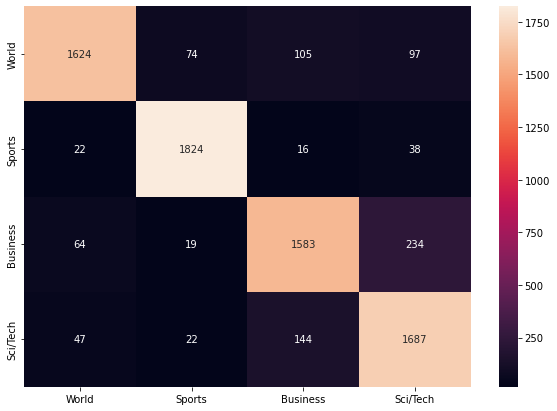

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(4, activation="softmax"))

model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
rnn_predictions = model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
rnn_predictions = np.argmax(rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, rnn_predictions)
print("\nTest Set Accuracy: ", accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

# Creating Example Predictions

To test the model, some fresh sample news were created (copied them from a news site like BBC) to see if the model can predict the correct labels. One example was used per class.

Also, one example that gets misclassified was found.

In [18]:
sample_news = list()
# Creating some fresh sample news (copied them from a news site like BBC) to see if the model can predict the correct labels
# Using one example per class
sample_news.append("Secretary of State Antony Blinken and Mexican President Andrés \
                   Manuel López Obrador discussed how to stop the flow of people \
                   in talks held in Mexico City.") # world news

sample_news.append("Newcastle United are confident they can agree a deal to sign \
                   England midfielder Kalvin Phillips from Manchester City but \
                   face competition from Juventus, Everton and Crystal Palace \
                   for the 28-year-old") # Sports news

sample_news.append("virgin blue shares plummet 20% shares in australian budget \
                   airline virgin blue plunged 20% after it warned of a steep \
                   fall in full year profits.  virgin blue said profits after \
                   tax for the year to march would be between 10% to 15% lower \
                   than the previous year.") # Business news

sample_news.append("There was a time when more than one of your TVs, computers, \
                   speaker systems or other essential electronic goods would \
                   have been made by Toshiba.")  # sci/tech news

# One example that gets misclassified.
sample_news.append("As her club sound goes overground, the Korean-born \
                   musician comes third in Radio 1's Sound of 2024.") # Entertainment news

# preprocessing the sample news
sample_news = [preprocess_text(i) for i in sample_news]
sample_news = remove_stopwords(sample_news)

# Lemmatization of the fresh sample news
sample_news = lemmatize_words(sample_news)

# vectorizing the sample news
sample_news_vectorized = vectorizer(sample_news)

# predict using the neural network
prediction = model.predict(sample_news_vectorized)
prediction = np.argmax(prediction, axis=1)
for i in prediction:
     print("NN classifier prediction: ", label_names[prediction[i]], "News")


1/1 [==============================] - 0s 34ms/step
NN classifier prediction:  World News
NN classifier prediction:  Sports News
NN classifier prediction:  Business News
NN classifier prediction:  Sci/Tech News
NN classifier prediction:  Sports News


The misclassification of a particular news article stems from its content being related to entertainment, a category not explicitly covered during the training of the neural network.

In the absence of specific training on entertainment news, the model lacks the necessary knowledge to accurately classify such articles.

Consequently, the model resorts to assigning the news article to the category with the highest probability among the classes it was trained on, resulting in an inaccurate classification.

To enhance the model's performance on entertainment-related content, it would be imperative to include relevant training data and possibly fine-tune the model to recognize patterns specific to this genre.

## A new model
Improving the RNN model that beats the baseline RNN

Given the nature of the task that revolves around modeling sequential data, it is prudent to maintain the utilization of a recurrent neural network (RNN). The decision to retain the RNN is grounded in its effectiveness in handling sequential data, particularly in the domain of Natural Language tasks. This choice aligns with established practices in leveraging RNNs for their inherent capabilities in capturing contextual dependencies within sequential information. [4].

The following are the strategies that will be adopted in an attempt to improve the performance of the model in terms of its accuracy

 - **Number of neurons :**
      As an initial strategy to improve the neural network's performance, an adjustment to the model complexity will be made. Specifically, the number of units within the LSTM layer will be increased from 32 to 64. This modification aims to empower the model in capturing more intricate patterns inherent in the data [5].
        
      
 - **Number of Epoch :**
      Training the model for an extended number of epochs offers increased chances for generalization beyond the training set, potentially enhancing performance on unseen data and contributing to a more robust overall generalization. The epoch will be increased from 5 in the baseline model to 15 in the following model training..


 - **Early stopping :**
     Another technique to consider is early stopping, a strategy that terminates training when a specified criterion is reached. This involves monitoring the validation error and halting training if there is no significant decrease after a set number of epochs. Early stopping has the potential to enhance generalization by preventing overfitting. Increasing the number of epochs facilitates ongoing performance monitoring and fine-tuning of the model.


In the initial model, validation loss and accuracy fluctuated, worsening at the fourth epoch but improving afterward. Extending the number of epochs enables a more thorough evaluation, and the addition of early stopping ensures efficient training by terminating when no substantial improvement is detected, therefor avoiding overfitting and saving time.

### Retraining the model with increased `neurons` and `epochs`

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 226,564
Trainable params: 226,564
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
750/750 [==============================] - 124s 159ms/step - loss: 0.4363 - accuracy: 0.8428 - val_loss: 0.3442 - val_accuracy: 0.8830
Epoch 2/10
750/750 [==============================] - 105s 140ms/step - loss: 0.3134 - accuracy: 0.8

<AxesSubplot:>

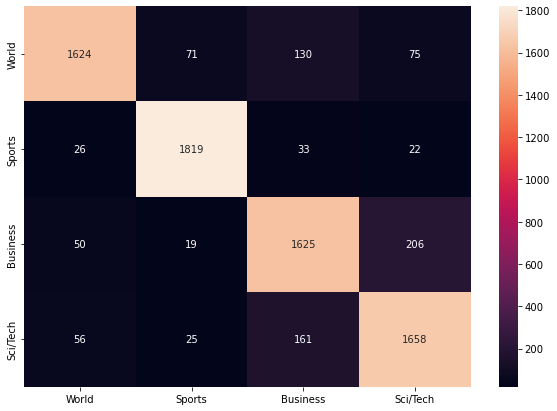

In [19]:
# Instantiating the Model
tuned_model = Sequential()
tuned_model.add(Embedding(vocab_size, 64)) 
tuned_model.add(Bidirectional(LSTM(64))) # Increasing the number of units
tuned_model.add(Dense(4, activation="softmax"))

tuned_model.summary()

# compile the model
tuned_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# fit the model
tuned_model.fit(
    train_data_vectorized,
    train_labels,
    epochs=10,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
    callbacks=[early_stopping], # including early stopping
)

# predict the labels on the test data
tuned_rnn_predictions = tuned_model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
tuned_rnn_predictions = np.argmax(tuned_rnn_predictions, axis=1)

# calculate the accuracy score
tuned_model_accuracy = accuracy_score(test_labels_list, tuned_rnn_predictions)
print("\nTest Set Accuracy: ", tuned_model_accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, tuned_rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

#### Making Predictions with the newly trained model

In [20]:
# predict using the neural network
prediction = tuned_model.predict(sample_news_vectorized)
prediction = np.argmax(prediction, axis=1)
for i in prediction:
     print("NN classifier prediction: ", label_names[prediction[i]], "News")

1/1 [==============================] - 0s 41ms/step
NN classifier prediction:  World News
NN classifier prediction:  Sports News
NN classifier prediction:  Business News
NN classifier prediction:  Sci/Tech News
NN classifier prediction:  Sports News


The obtained results indicate a slight improvement of 0.11% in the test accuracy, signifying improved performance of the model on previously unseen data in comparison to the baseline model.

However, a noteworthy concern arises upon inspecting the confusion matrix heatmap, revealing an increase in the number of misclassification for some of the classes in the newly trained model and only `Business news` class shows a significant improvement in its classification.

This shift in the confusion matrix pattern may be attributed to the potential influence of an imbalanced dataset.

Observing the model metrics, the validation accuracy attained its highest value at 4th epoch, then keeps flunctuating afterwards while the training accuracy continued to increase. This is an indication of overfitting as the model was struggling to generalize to unseen data.

### Retraining the model with increased batch size

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          80000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 130,180
Trainable params: 130,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 96s 240ms/step - loss: 0.5242 - accuracy: 0.8056 - val_loss: 0.3636 - val_accuracy: 0.8761
Epoch 2/10
375/375 [==============================] - 76s 203ms/step - loss: 0.3383 - accuracy: 0.884

<AxesSubplot:>

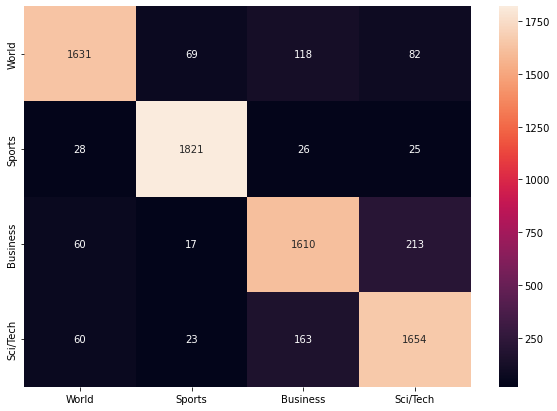

In [21]:
# Instantiating the Model
second_tuned_model = Sequential()
second_tuned_model.add(Embedding(vocab_size, 32)) 
second_tuned_model.add(Bidirectional(LSTM(64))) # The number of units has been increased to 64 as against 32 in the baseline model
second_tuned_model.add(Dense(4, activation="softmax"))

second_tuned_model.summary()

# compile the model
second_tuned_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# fit the model
second_tuned_model.fit(
    train_data_vectorized,
    train_labels,
    epochs=10,
    batch_size=256,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
    callbacks=[early_stopping],
)

# predict the labels on the test data
second_tuned_rnn_predictions = second_tuned_model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
second_tuned_rnn_predictions = np.argmax(second_tuned_rnn_predictions, axis=1)

# calculate the accuracy score
second_tuned_model_accuracy = accuracy_score(test_labels_list, second_tuned_rnn_predictions)
print("\nTest Set Accuracy: ", second_tuned_model_accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, second_tuned_rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

## Discussion


After applying text preprocessing, the baseline model achieved an accuracy of 88.39%, which is slightly lower than the 88.51% accuracy observed before text preprocessing.

The removal of specific words, such as extremely rare or frequently occurring ones like `https`, `http`, `href`, and news agency names, aims to reduce noise in the dataset. Noise in the form of irrelevant or frequently occurring words may not contribute significantly to contextual understanding and could introduce unwanted complexity. By excluding such words and reducing the dimensionality of the input space, the model becomes more focused on meaningful patterns.

In the initial tuning of the RNN model, which involved increasing the number of units in each layer, a slight improvement in accuracy was observed compared to the baseline model. This improvement suggests that the neural network, with increased units, could capture more intricate patterns in the data.

However, the subsequent tuning, which included reducing the number of units in the first layer, resulted in a performance drop compared to the previously tuned model. The reduced number of neurons in the network may have hindered its ability to capture complex underlying patterns in the dataset.

Surprisingly, the best-performing model after text preprocessing and tuning exhibited a lower test accuracy compared to the model trained on the dataset without text preprocessing. This decrease in accuracy may be attributed to noise or errors in the original test data that negatively affected model training but did not impact testing.

While `accuracy` was used for evaluation, employing more robust metrics such as `balanced accuracy`, `F1 score`, `recall`, and `precision` could compensate for potential imbalances in the dataset, which might affect the model.


Furthermore, multiple training sessions of the RNN model aimed at obtaining better performance showed consistently changing results in metrics. This variability is primarily due to the randomness in the initialization of weights used by the neural network.

# References

[1] Lemmatization definition : https://towardsdatascience.com/stemming-vs-lemmatization-in-nlp-dea008600a0

[2] Lemmatization : https://www.quora.com/What-is-lemmatization-in-NLP

[3] Lemmatization and AI models : https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf (pg 32)

[4] News samples : https://www.bbc.com/news/

[5] Increasing the number of units in the neural network : https://saturncloud.io/blog/how-to-improve-accuracy-in-neural-networks-with-keras/#:~:text=Increase%20the%20Number%20of%20Neurons,can%20lead%20to%20better%20predictions

[5] Recurrent Neural Network and Natural Language Processing : https://www.tensorflow.org/guide/keras/working_with_rnns